In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mendelai-brat-parser
from brat_parser import get_entities_relations_attributes_groups

import torch 
import spacy
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt

  Created wheel for mendelai-brat-parser: filename=mendelai_brat_parser-0.0.11-py3-none-any.whl size=4945 sha256=3749290b420123e769d74b985c6946fd540150201f47f72b5c761db1ec0e5c20
  Stored in directory: /root/.cache/pip/wheels/7e/40/73/4f68f4fa597be33e250400cd56c28c85862b1cba5b3c7c33f1
Successfully built mendelai-brat-parser


# EDA

In [ ]:
file_no = "291-02"
base = "/content/drive/MyDrive/CMED/Data/trainingdata_v3/train/" + file_no

###################################################################################################

entities, relations, attributes, groups = get_entities_relations_attributes_groups( base + ".ann" )

with open(base + ".txt") as txt:
  txt = txt.read()

l = []

for i in entities:
  l.append(list(entities[i].span[0])+list((entities[i].type,)))

l = sorted(l,reverse = True)
#print(l)
for i in range(1,len(l)):
  if l[i][0] == l[i-1][0] and l[i][1] == l[i-1][1]:
    l[i-1] = None
    if (l[i-1]!=l[i]):
      l[i][2] = "MULTIPLE"

for e in l:
  if e == None:
    continue
  if e[2] == "NoDisposition":
    txt = txt[:e[0]] + '\033[91m' + '\033[1m' + txt[e[0]:e[1]] + '\033[0m' + txt[e[1]:] 
  elif e[2] == "Disposition":
    txt = txt[:e[0]] + '\033[92m' + '\033[1m' + txt[e[0]:e[1]] + '\033[0m' + txt[e[1]:] 
  elif e[2] == "Undetermined" :
    txt = txt[:e[0]] + '\033[94m' + '\033[1m' + txt[e[0]:e[1]] + '\033[0m' + txt[e[1]:] 
  else:
    txt = txt[:e[0]] + '\033[95m' + '\033[1m' + txt[e[0]:e[1]] + '\033[0m' + txt[e[1]:] 
print( '\033[92;1m' + "Green"  + " -> Disposition" + '\033[0m')
print('\033[94;1m' + "Blue" + " -> Undetermined" + '\033[0m')
print('\033[91;1m' + "RED" + " -> NoDisposition" + '\033[0m' )
print('\033[95;1m' + "PINK" + " -> Assigned to Multiple classes" + '\033[0m' )

print(txt)

Green -> Disposition
Blue -> Undetermined
RED -> NoDisposition
PINK -> Assigned to Multiple classes



Record date: 2095-12-13

TEAM 2 ACCEPT NOTE

Patient's name: Frank Keatering	
MRN: 	4832978
Date of Admission to MICU: 	12/11/95
Date of transfer to Internal Medicine: 	12/13/95

ID/CC:  acute loss of motor/sensation at level of T8

History Obtained From: Pt, old charts, transfer note.

History of Present Illness:  74 y/o man with h/o paraplegia 2/2 compression fracture and wheelchair bound, vascular dz, with recent bilateral ileofemoral and renal artery stent (11/24/95) and recent cardiac cath stent to the circumflex (11/28/95). Pt presented to OSH 12/10 with c/o abdominal pain onset the PM prior to admission, diffuse in nature, localized in the mid-epigastric region, RUQ, and LUQ with a pain scale of 8-10/10 pain. Per charts he reported decreased pain in the am with ability to tolerate PO's and then increasing pain that afternoon. Also associated with diaphoresis, + nausea, no vomit

In [ ]:
df = pd.read_csv( base + ".ann" , header = None )

mapper = {}
for i in df.index:
  if df[0][i].startswith("E"):
    mapper[df[0][i].split("\t")[0]] = df[0][i].split(':')[-1].strip()
del df


df = pd.DataFrame(columns = ["EVENT","STATEMENT","SPAN","Actor","Action","Certainty","Temporality","Negation"],index = [x for x in entities])

for e in entities:
  df.loc[e,"EVENT"] = entities[e].type
  df.loc[e,"STATEMENT"] = entities[e].text
  assert(entities[e].span.__len__() == 1)
  df.loc[e,"SPAN"] = entities[e].span[0]

for e in attributes:
  assert(bool(df.loc[mapper[attributes[e].target],attributes[e].type])),str(df.loc[mapper[attributes[e].target],attributes[e].type])
  df.loc[mapper[attributes[e].target],attributes[e].type] = attributes[e].values[0]
df = df.sort_values(["EVENT","SPAN"])
df

,EVENT,STATEMENT,SPAN,Actor,Action,Certainty,Temporality,Negation
T1,Disposition,Morphine,"(1099, 1107)",Physician,UniqueDose,Certain,Past,NotNegated
T2,Disposition,dopamine,"(1224, 1232)",Physician,Start,Certain,Past,NotNegated
T3,Disposition,pRBC,"(1915, 1919)",Physician,UniqueDose,Certain,Past,NotNegated
T5,Disposition,Abx,"(2223, 2226)",Physician,UniqueDose,Certain,Past,NotNegated
T6,Disposition,zosyn,"(2228, 2233)",Physician,UniqueDose,Certain,Past,NotNegated
T7,Disposition,flagyl,"(2235, 2241)",Physician,UniqueDose,Certain,Past,NotNegated
T53,Disposition,vanc,"(2246, 2250)",Physician,UniqueDose,Certain,Past,NotNegated
T54,Disposition,methylene blue,"(3621, 3635)",Physician,UniqueDose,Certain,Past,NotNegated
T10,Disposition,ASA,"(4409, 4412)",Physician,Stop,Certain,Past,NotNegated
T11,Disposition,plavix,"(4414, 4420)",Physician,Stop,Certain,Past,NotNegated


Number of text files: 350
Number of annotation files: 350
Total number of entities: 6196


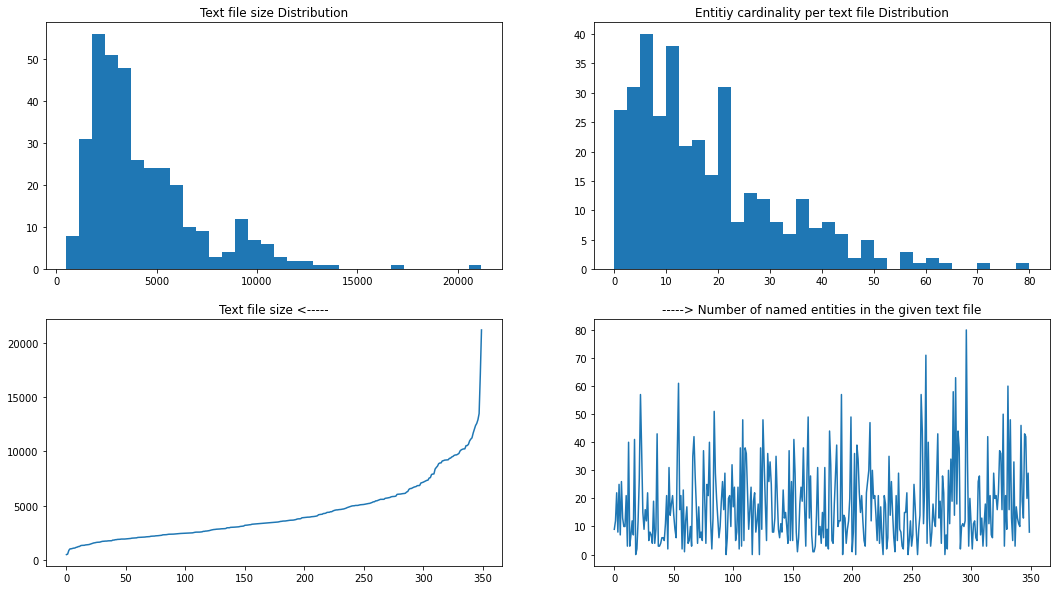

In [ ]:
l = []
ln = []
ent = []

for i in glob("/content/drive/MyDrive/CMED/Data/trainingdata_v3/train/*"):
  if i.endswith(".txt"):
    with open(i) as txt:
      l.append(txt.read().__len__())
  elif i.endswith(".ann"):
    entities, relations, attributes, groups = get_entities_relations_attributes_groups(i)
    ln.append(len(entities))
    ent.append(entities)
print("Number of text files:",len(l))
print("Number of annotation files:",len(ln))
print("Total number of entities:",sum(ln))
fig,ax = plt.subplots(2,2,figsize = (18,10))
_ = ax[0][0].hist(l,bins = 32)
_ = ax[0][1].hist(ln,bins = 32)
_ = ax[1][0].plot(range(len(l)),np.sort(np.array(l)))
_ = ax[1][1].plot(range(len(l)),np.array(ln)[np.argsort(np.array(l))])
ax[0][0].set_title("Text file size Distribution")
ax[0][1].set_title("Entitiy cardinality per text file Distribution")
ax[1][0].set_title("Text file size <-----")
_ = ax[1][1].set_title("-----> Number of named entities in the given text file")

Class distribution of different medical entities
Consider the uneven scale


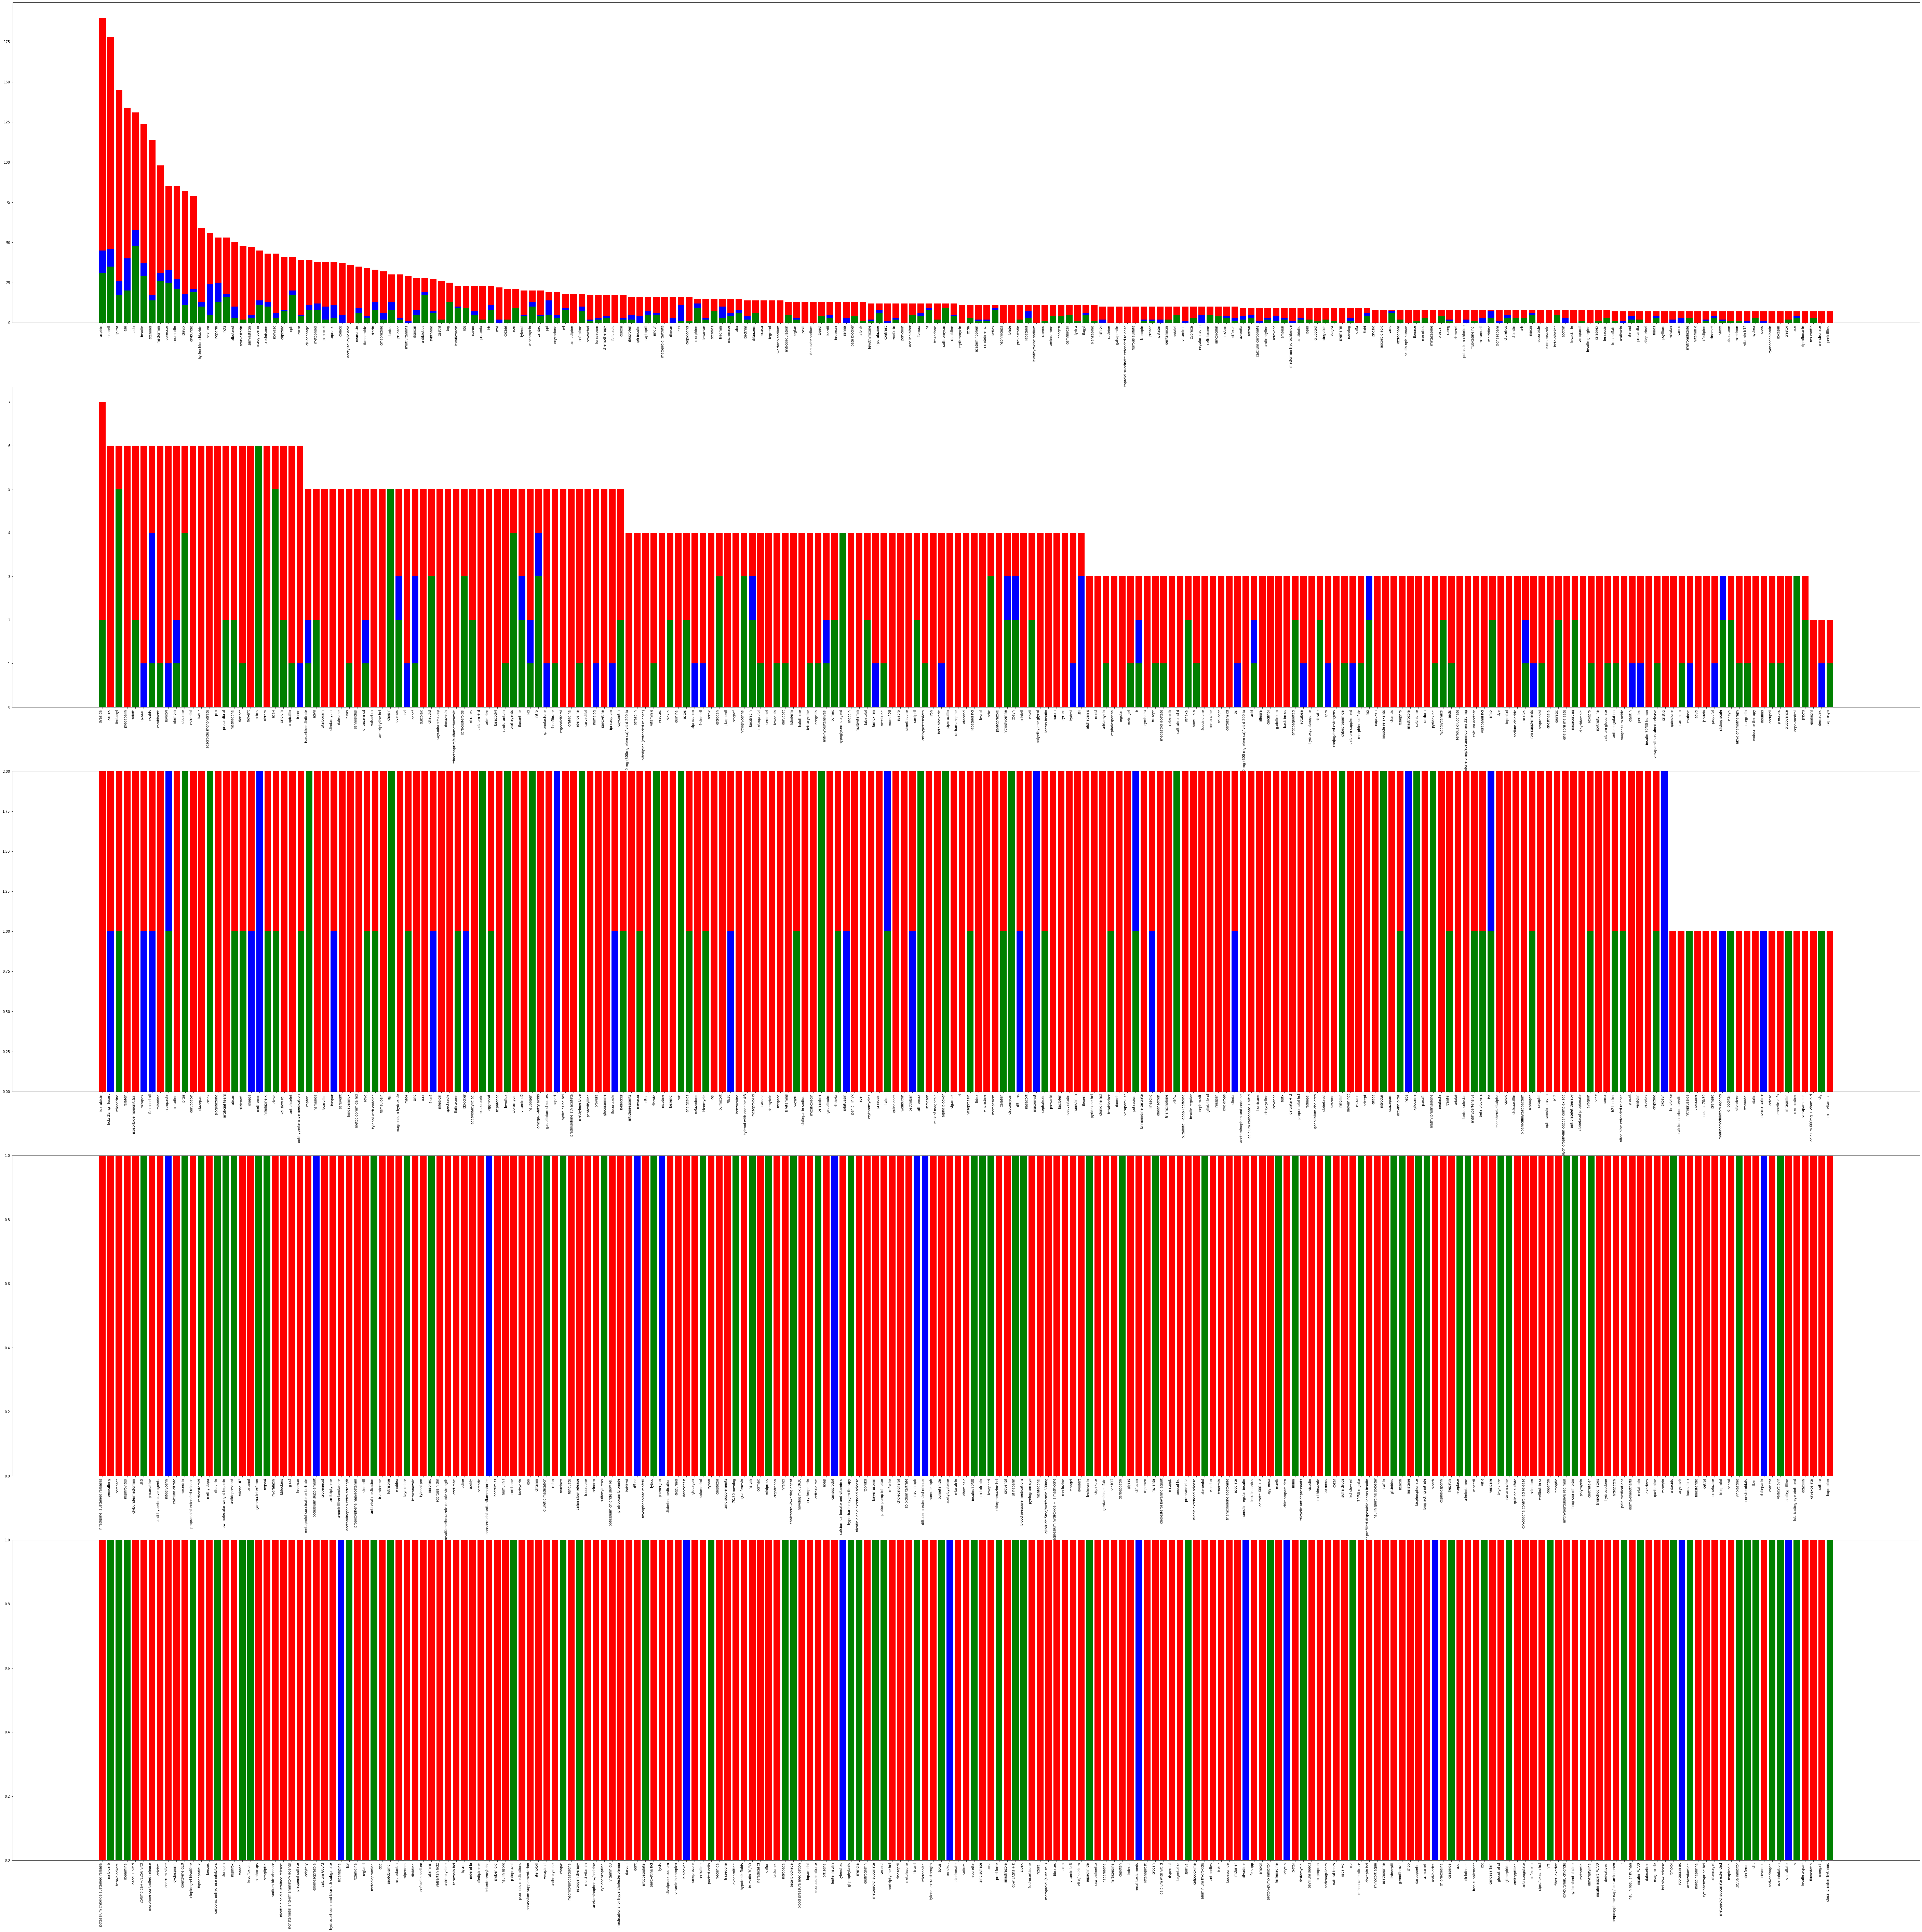

In [ ]:
cntd = {}
cntnd = {}
cntu = {}

for e in ent:
  for j in e:
    if e[j].type == "NoDisposition":
      if e[j].text.lower() in cntnd:
        cntnd[e[j].text.lower()] += 1
      else:
        cntnd[e[j].text.lower()] = 1
    elif e[j].type == "Disposition":
      if e[j].text.lower() in cntd:
        cntd[e[j].text.lower()] += 1
      else:
        cntd[e[j].text.lower()] = 1
    elif e[j].type == "Undetermined":
      if e[j].text.lower() in cntu:
        cntu[e[j].text.lower()] += 1
      else:
        cntu[e[j].text.lower()] = 1

lst = list(set(cntu).union(set(cntd)).union(set(cntnd)))
lst = list(np.array(lst)[np.argsort(np.array([(cntd[x] if x in cntd else 0) + (cntu[x] if x in cntu else 0 ) + (cntnd[x] if x in cntnd else 0 ) for x in lst]))[::-1]])

fig,ax = plt.subplots(5,1,figsize = (100,100),sharey = False)
for i in range(5):
  l = np.array(lst)[(i*len(lst)//5):((i+1)*len(lst)//5) if i<4 else len(lst)]
  _ = ax[i].bar(l,[cntd[x] if x in cntd else 0 for x in l],color = 'green')
  _ = ax[i].bar(l,[cntu[x] if x in cntu else 0 for x in l],bottom = [cntd[x] if x in cntd else 0 for x in l],color = "blue")
  _ = ax[i].bar(l,[cntnd[x] if x in cntnd else 0 for x in l],bottom = [(cntd[x] if x in cntd else 0) + (cntu[x] if x in cntu else 0 ) for x in l],color = "red")
  _ = ax[i].set_xticklabels(labels = l,rotation = 90,ha = "right")

print("Class distribution of different medical entities")
print("Consider the uneven scale")

In [ ]:
entities, relations, attributes, groups = get_entities_relations_attributes_groups( base + ".ann" )


In [ ]:
entities["T71"],entities["T70"]

(Entity(id='T71', type='Disposition', span=((20868, 20881),), text='sliding scale'),
 Entity(id='T70', type='Undetermined', span=((20868, 20881),), text='sliding scale'))

In [ ]:
# Notes:

# Remove parenthesis from the text.
# To check: 100-03 Zolpidem tartrate ambiguous.
# make sentences lowercase.
# Beware of Datetime data in text.
# Record date can't be understood. Record date is useful for certainity.
# some items are assigned to multiple classes creating problem.
# Extremely unbalanced data in every level of classification.
# Sentence division to be taken care of